#Лабораторная работа по курсу

#Загружаем данные

In [1]:
# скачиваем данные
!wget 'https://archive.ics.uci.edu/static/public/40/flags.zip'

--2024-11-20 06:29:38--  https://archive.ics.uci.edu/static/public/40/flags.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘flags.zip’

flags.zip               [ <=>                ]   5.72K  --.-KB/s    in 0s      

2024-11-20 06:29:38 (93.2 MB/s) - ‘flags.zip’ saved [5862]



In [2]:
import zipfile

# Путь к zip-архиву
archive_path = '/content/flags.zip'

# Распаковываем zip-архив
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
import pandas as pd
import numpy as np

cols = ['name','landmass','zone','area','population','language','religion','bars','stripes',
       'colours','red','green','blue','gold','white','black','orange','mainhue','circles',
       'crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate',
       'text','topleft','botright']

# загружаю датасет
data = pd.read_csv('/content/flag.data', header=None, names=cols)
data.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


#Анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        194 non-null    object
 1   landmass    194 non-null    int64 
 2   zone        194 non-null    int64 
 3   area        194 non-null    int64 
 4   population  194 non-null    int64 
 5   language    194 non-null    int64 
 6   religion    194 non-null    int64 
 7   bars        194 non-null    int64 
 8   stripes     194 non-null    int64 
 9   colours     194 non-null    int64 
 10  red         194 non-null    int64 
 11  green       194 non-null    int64 
 12  blue        194 non-null    int64 
 13  gold        194 non-null    int64 
 14  white       194 non-null    int64 
 15  black       194 non-null    int64 
 16  orange      194 non-null    int64 
 17  mainhue     194 non-null    object
 18  circles     194 non-null    int64 
 19  crosses     194 non-null    int64 
 20  saltires  

In [5]:
black_list = ['name'] # имя страны не рассматриваем
categoricals = ['landmass','zone','language','mainhue','topleft','botright']
dummies = ['red','green','blue','gold','white','black','orange','crescent','triangle','icon','animate','text']
continious = ['area', 'population', 'bars', 'stripes', 'colours','circles', 'crosses', 'saltires', 'quarters', 'sunstars']
target = 'religion'

In [6]:
data[continious].describe()

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,700.046392,23.268041,0.453608,1.551546,3.463918,0.170103,0.149485,0.092784,0.149485,1.386598
std,2170.927932,91.934085,1.038339,2.328005,1.300154,0.463075,0.385387,0.290879,0.435860,4.396186
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,111.000000,4.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,471.250000,14.000000,0.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,22402.000000,1008.000000,5.000000,14.000000,8.000000,4.000000,2.000000,1.000000,4.000000,50.000000


In [7]:
data[data.area == 0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue
33,Cayman-Islands,1,4,0,0,1,1,0,0,6,...,1,1,4,0,0,1,1,1,white,blue
41,Cook-Islands,6,3,0,0,1,1,0,0,4,...,1,1,15,0,0,0,0,0,white,blue
48,Dominica,1,4,0,0,1,1,0,0,6,...,0,0,10,0,0,0,1,0,green,green


In [8]:
data[data.population==0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
12,Bahamas,1,4,19,0,1,1,0,3,3,...,0,0,0,0,1,0,0,0,blue,blue
13,Bahrain,5,1,1,0,8,2,0,0,2,...,0,0,0,0,0,0,0,0,white,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
17,Belize,1,4,23,0,1,1,0,2,8,...,0,0,0,0,0,1,1,1,red,red
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue


In [9]:
data[dummies].agg(['min','max', 'nunique', 'mean'])

,red,green,blue,gold,white,black,orange,crescent,triangle,icon,animate,text
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
nunique,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.78866,0.469072,0.510309,0.469072,0.752577,0.268041,0.134021,0.056701,0.139175,0.252577,0.201031,0.082474


In [10]:
dummies

['red',
 'green',
 'blue',
 'gold',
 'white',
 'black',
 'orange',
 'crescent',
 'triangle',
 'icon',
 'animate',
 'text']

In [11]:
data[continious]

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars
0,648,16,0,3,5,0,0,0,0,1
1,29,3,0,0,3,0,0,0,0,1
2,2388,20,2,0,3,0,0,0,0,1
3,0,0,0,0,5,0,0,0,0,0
4,0,0,3,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
189,3,0,0,0,3,0,0,0,1,5
190,256,22,0,3,4,0,0,0,0,1
191,905,28,0,0,4,1,0,0,0,0
192,753,6,3,0,4,0,0,0,0,0


In [12]:
y = data[target]
y.head()

,religion
0,2
1,6
2,2
3,1
4,0


In [13]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
5,27
6,15
3,8
4,4
7,4


In [14]:
def union_classes(x):
    if x in [3,4,7]:
        return 3
    elif x==6:
        return 5
    elif x==5:
        return 4
    else:
        return x

In [15]:
data['religion'] = data['religion'].apply(union_classes)

In [16]:
y = data[target]

In [17]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [18]:
X = pd.concat([data[continious], data[dummies],
               pd.get_dummies(data[categoricals])],
               axis=1
             )
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   area             194 non-null    int64
 1   population       194 non-null    int64
 2   bars             194 non-null    int64
 3   stripes          194 non-null    int64
 4   colours          194 non-null    int64
 5   circles          194 non-null    int64
 6   crosses          194 non-null    int64
 7   saltires         194 non-null    int64
 8   quarters         194 non-null    int64
 9   sunstars         194 non-null    int64
 10  red              194 non-null    int64
 11  green            194 non-null    int64
 12  blue             194 non-null    int64
 13  gold             194 non-null    int64
 14  white            194 non-null    int64
 15  black            194 non-null    int64
 16  orange           194 non-null    int64
 17  crescent         194 non-null    int64
 18  triangle  

#Подготовим данные

In [19]:
# разобрьем данные на тест т трейн
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
                                                   )

#RandomForestClassifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [21]:
# построим модель RandomForestClassifier по умолчанию
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [22]:
# построим модель StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [23]:
score_on_train = 0
for trn_idx,tst_idx in skf.split(X_train, y_train):
    X_train_fold, y_train_fold = X.iloc[trn_idx], y.iloc[trn_idx]
    X_test_fold, y_test_fold = X.iloc[tst_idx], y.iloc[tst_idx]
    rfc.fit(X_train_fold, y_train_fold)
    score_on_train += rfc.score(X_test_fold, y_test_fold)

rfc.fit(X_train, y_train)
print(f'score_on_train={score_on_train/3 :.3f}')
print(f'score_on_test ={rfc.score(X_test, y_test) :.3f}')

score_on_train=0.665
score_on_test =0.641


Подберем лучшие параметры для RandomForestClassifier

In [24]:
from sklearn.model_selection import GridSearchCV

In [105]:
# зададим возможные параметры
param_grid = {'max_depth': [6, 8],
              'max_features': [None],
              'max_leaf_nodes': [6, 8, 10],
              'min_samples_leaf': [4, 6],
              'min_samples_split': [4, 6],
              'n_estimators': [50, 60, 70]
             }

In [106]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [107]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [108]:
# обучим
rfc_grid.fit(X_train, y_train)
rfc_grid

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8], 'max_features': [None],
                         'max_leaf_nodes': [6, 8, 10],
                         'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 6],
                         'n_estimators': [50, 60, 70]},
             verbose=True)

In [109]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 60}

In [110]:
# получим и обучим нашу лучшую модель
rfc_best = rfc_grid.best_estimator_
rfc_best.fit(X_train, y_train)
rfc_best

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=8,
                       min_samples_leaf=4, min_samples_split=4, n_estimators=60,
                       n_jobs=-1, random_state=42)

In [111]:
# получим метрики
score_on_train = rfc_best.score(X_train, y_train)
score_on_test = rfc_best.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=0.781
score_on_test =0.615


In [115]:
X_train.shape

(155, 48)

In [113]:
# посмотрим на важность признаков
importances = rfc_best.feature_importances_
importances

array([0.06111736, 0.01983508, 0.00453538, 0.00238812, 0.00439709,
       0.00289835, 0.01902233, 0.        , 0.00109262, 0.00137482,
       0.        , 0.00615161, 0.01949417, 0.00801693, 0.00371421,
       0.00320483, 0.        , 0.        , 0.        , 0.        ,
       0.00752129, 0.        , 0.35263928, 0.07266554, 0.40534721,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00103958, 0.        , 0.        , 0.0012772 ,
       0.        , 0.        , 0.        , 0.        , 0.00112495,
       0.        , 0.00114204, 0.        ])

In [121]:
y_train

,religion
183,1
53,4
162,2
23,0
110,2
...,...
168,3
39,2
78,3
48,1


In [127]:
std = np.std([tree.feature_importances_ for tree in rfc_best.estimators_], axis=0)

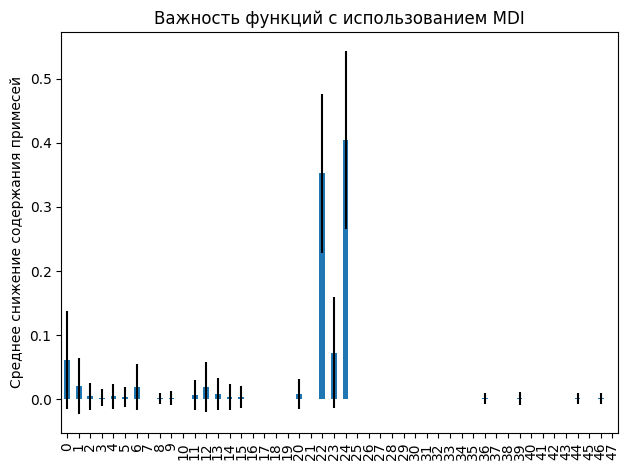

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Важность функций с использованием MDI')
ax.set_ylabel('Среднее снижение содержания примесей')
fig.tight_layout()

Определение избыточной выборки